In [199]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Reshape
from keras.datasets import mnist
from keras.optimizers import Adam,SGD
from keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [200]:
initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

In [212]:
epochs=2
e_h_1=1000
e_h_2=1000
encoded_dim=8
d_h_1=1000
d_h_2=1000
disc_h_1=1000
disc_h_2=1000
img_shape=(28,28,1)
optimizer_reconst=Adam(0.001)
optimizer_discriminator=Adam(0.0004)
optimizer_encoder_discriminator=Adam(0.0001)

In [213]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.reshape(x_train.shape[0],28,28,1).astype(np.float32)
x_train = x_train.astype(np.float32) -127.5 / 127.5
x_test=x_test.reshape(x_test.shape[0],28,28,1).astype(np.float32)
x_test = x_test.astype(np.float32) -127.5 / 127.5
#x_test = x_test.astype(np.float32) / 255.

In [215]:
##Encoder model

x_input=Input(img_shape)
flatten_layer=Flatten(input_shape=img_shape)(x_input)
encoder_hidden_1=Dense(e_h_1,activation='relu',kernel_initializer=initializer,
                       bias_initializer=initializer)(flatten_layer)
encoder_hidden_2=Dense(e_h_2,activation='relu',kernel_initializer=initializer,
                       bias_initializer=initializer)(encoder_hidden_1)
z_code=Dense(encoded_dim,activation='linear',kernel_initializer=initializer,
                       bias_initializer=initializer)(encoder_hidden_2)
encoder=Model(inputs=x_input,outputs=z_code)


In [216]:
##Decoder model


d_x_input=Input((encoded_dim,))
decoder_hidden_1=Dense(d_h_1,activation='relu',kernel_initializer=initializer,
                       bias_initializer=initializer)(d_x_input)
decoder_hidden_2=Dense(d_h_2,activation='relu',kernel_initializer=initializer,
                       bias_initializer=initializer)(decoder_hidden_1)
decoder_image=Dense(np.prod(img_shape),activation='tanh',kernel_initializer=initializer,
                       bias_initializer=initializer)(decoder_hidden_2)
gen_img=Reshape(img_shape)(decoder_image)

decoder=Model(inputs=d_x_input,outputs=gen_img)


In [217]:

#Discriminator


disc_x_input=Input((encoded_dim,))
disc_hidden_1=Dense(disc_h_1,activation='relu',kernel_initializer=initializer,
                       bias_initializer=initializer)(disc_x_input)
disc_hidden_2=Dense(disc_h_2,activation='relu',kernel_initializer=initializer,
                       bias_initializer=initializer)(disc_hidden_1)
real_or_fake=Dense(1,activation='sigmoid',kernel_initializer=initializer,
                       bias_initializer=initializer)(disc_hidden_2)
discriminator=Model(inputs=disc_x_input,outputs=real_or_fake)


In [218]:
##AutoEncoder

img=Input(shape=img_shape)
encoded_repr=encoder(img)
recons_img=decoder(encoded_repr)
AutoEncoder=Model(inputs=img,outputs=recons_img)



In [219]:

##encoder_discriminator


img1=Input(shape=img_shape)
encoded_repr=encoder(img1)
confidence=discriminator(encoded_repr)
Encoder_Discriminator=Model(inputs=img1,outputs=confidence)


AutoEncoder.compile(optimizer=optimizer_reconst,
                    loss='mse',metrics=['mse'])
discriminator.compile(optimizer=optimizer_discriminator,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
for layer in discriminator.layers:
    layer.trainable=False
Encoder_Discriminator.compile(optimizer=optimizer_encoder_discriminator,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [220]:
datagen=ImageDataGenerator(featurewise_std_normalization=True, samplewise_std_normalization=True)

C:\Users\sudha\python3.6\lib\site-packages\keras\preprocessing\image.py:526: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\sudha\python3.6\lib\site-packages\keras\preprocessing\image.py:533: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
##Training
batch_size=200
half_batch=int(batch_size/2)
d_err=[]
recons=[]
g_e_err=[]
for epoch in range(epochs):
    ctr=0
    for x_batch , _ in datagen.flow(x_train,y_train,batch_size=half_batch):
        ctr=ctr+1   
        imgs=x_batch
        latent_fake=encoder.predict(imgs)
        latent_real= 5*np.random.normal(size=(half_batch, encoded_dim))
        valid =0.9*np.ones((half_batch, 1))
        fake = 0.1*np.ones((half_batch, 1))
        d_loss_real = discriminator.train_on_batch(latent_real, valid)
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
        d_loss= 0.5 * np.add(d_loss_real, d_loss_fake)
        d_err.append(d_loss)
        #idx = np.random.randint(0, x_train.shape[0], batch_size)
        #imgs = x_train[idx]
        valid_y = 0.9*np.ones((half_batch, 1))
        g_loss_reconstruction = AutoEncoder.train_on_batch(imgs, imgs)
        recons.append(g_loss_reconstruction)
        #for i in range(5):
        g_loss_similarity= Encoder_Discriminator.train_on_batch(imgs, valid_y)
        g_e_err.append(g_loss_similarity)
        #print(g_loss_similarity)
        #print(g_loss_reconstruction)
        #quit()
        if ctr>600:
            AutoEncoder.save_weights(f'AAE_AE_weights{epoch}.h5')
            discriminator.save_weights(f'AAE_Disc_weights{epoch}.h5')
            Encoder_Discriminator.save_weights(f'AAE_ED_weights{epoch}.h5')
            break
        print ("%d [D loss: %f, acc: %.2f%%] [G bce: %f,acc: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1],
        g_loss_similarity[0], g_loss_similarity[1], g_loss_reconstruction[1]))
        #print ("%d [ mse: %f]" % (epoch, g_loss_reconstruction[1]))
#AutoEncoder.fit(x=x_train,y=x_train, epochs=15)

#AutoEncoder.save_weights('AAE_AE_weights.h5')
#discriminator.save_weights('AAE_Disc_weights.h5')
#Encoder_Discriminator.save_weights('AAE_ED_weights.h5')

In [13]:
AutoEncoder.load_weights('AAE_AE_weights.h5')
discriminator.load_weights('AAE_Disc_weights.h5')
Encoder_Discriminator.load_weights('AAE_ED_weights.h5')

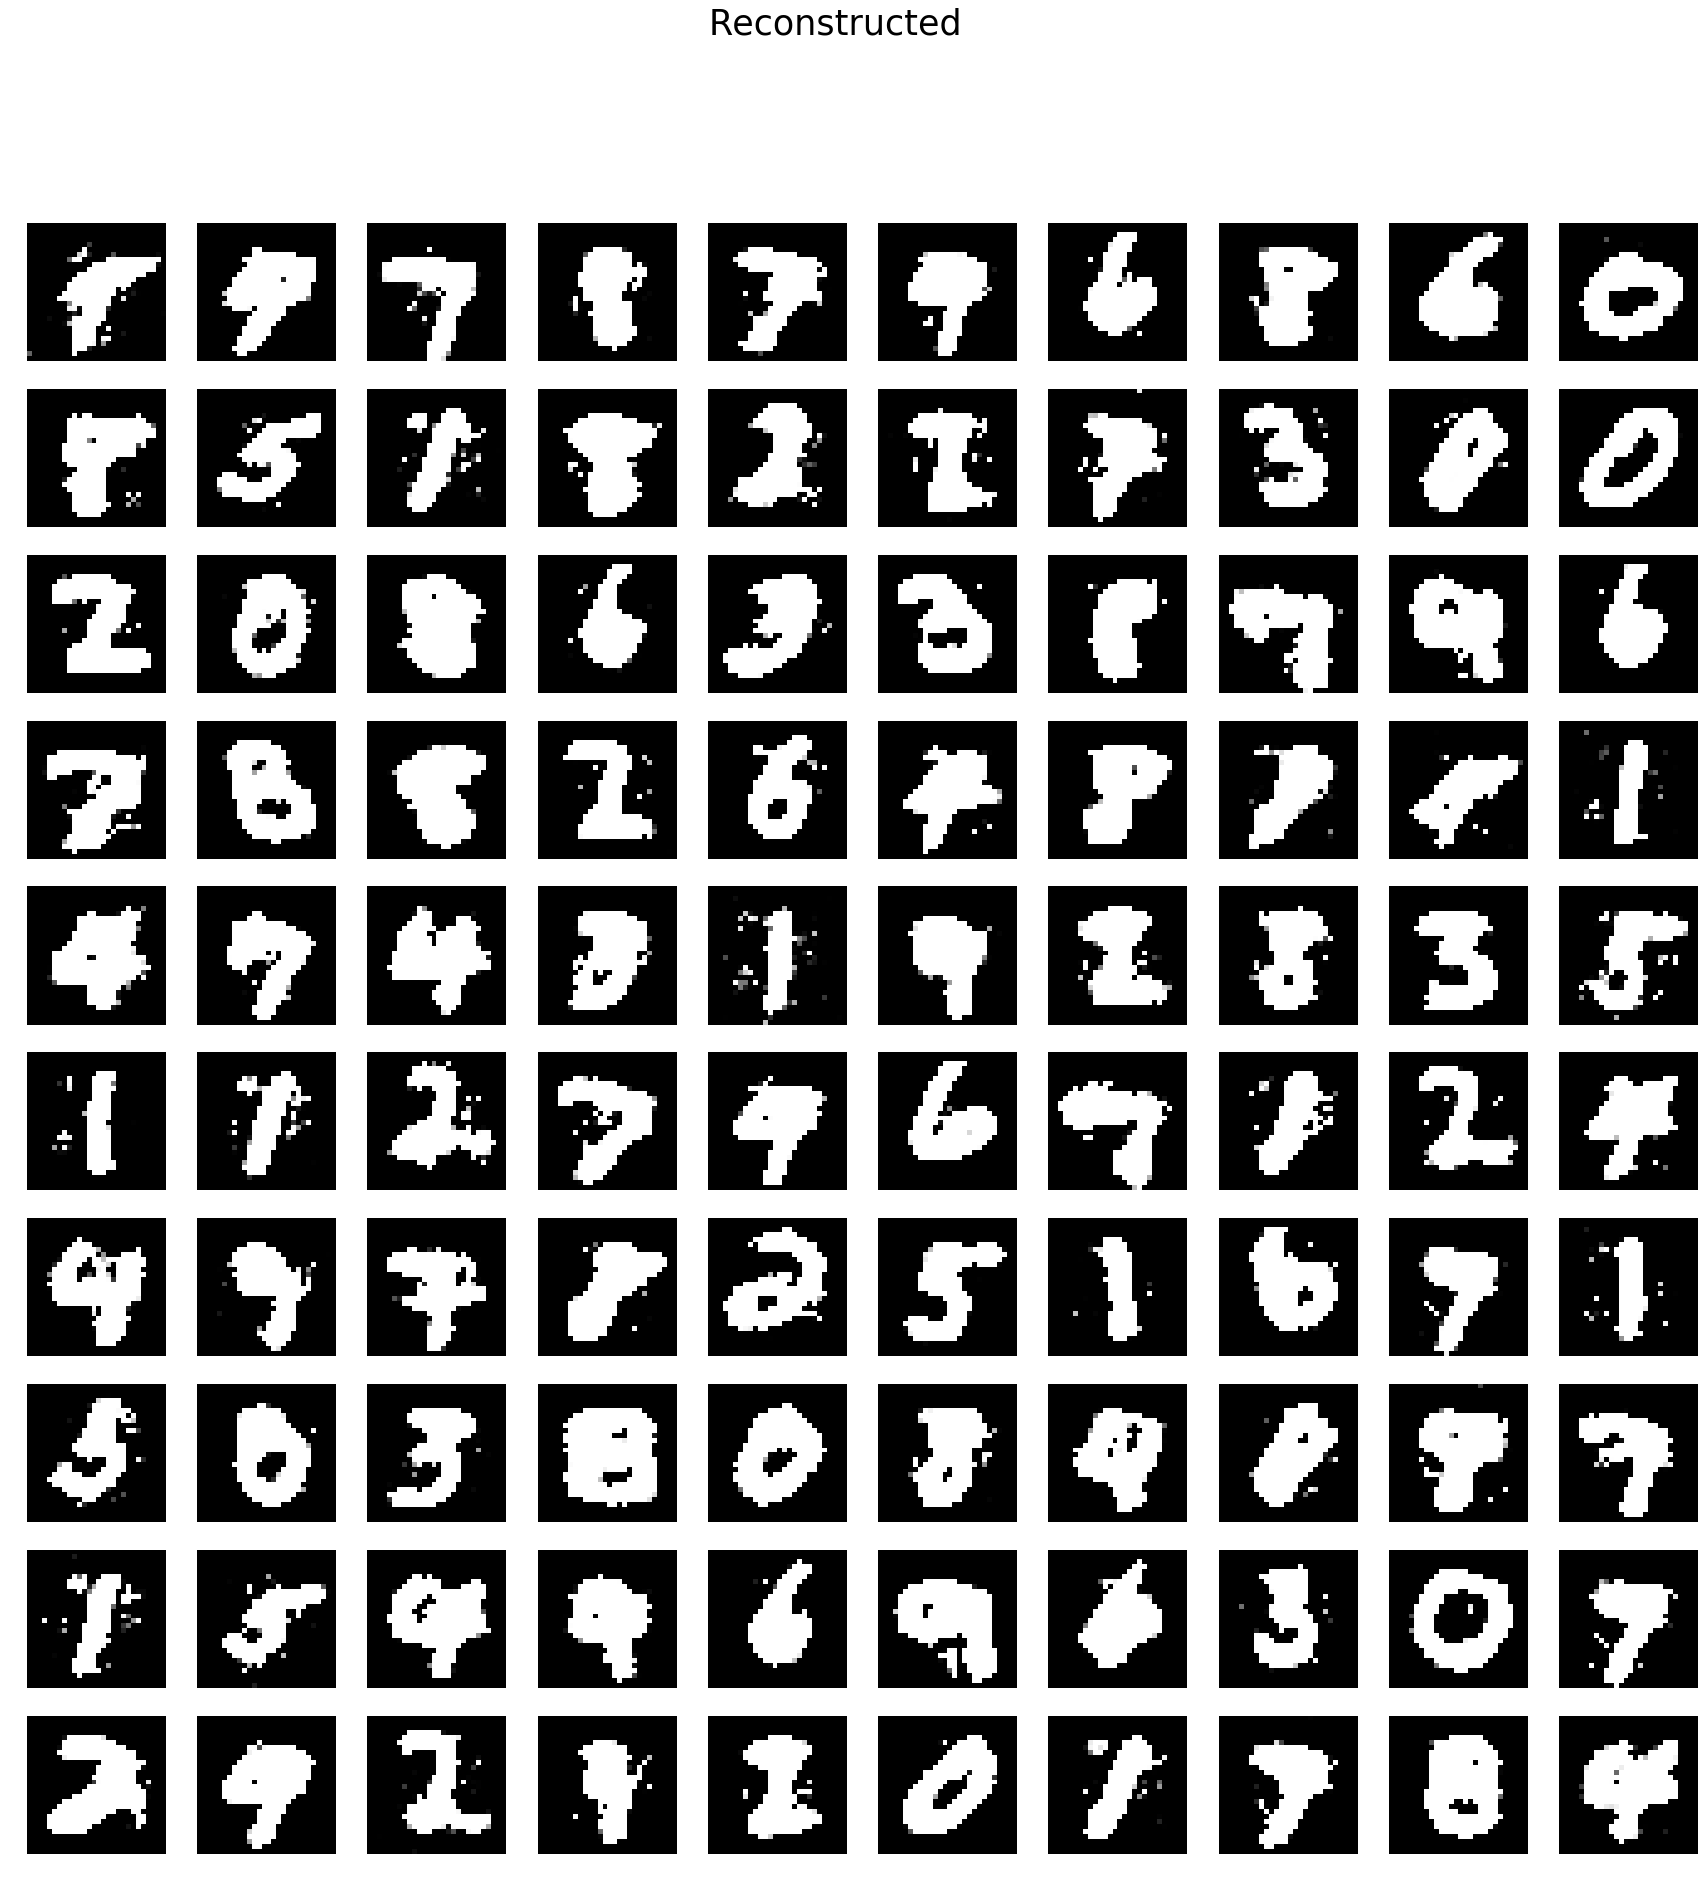

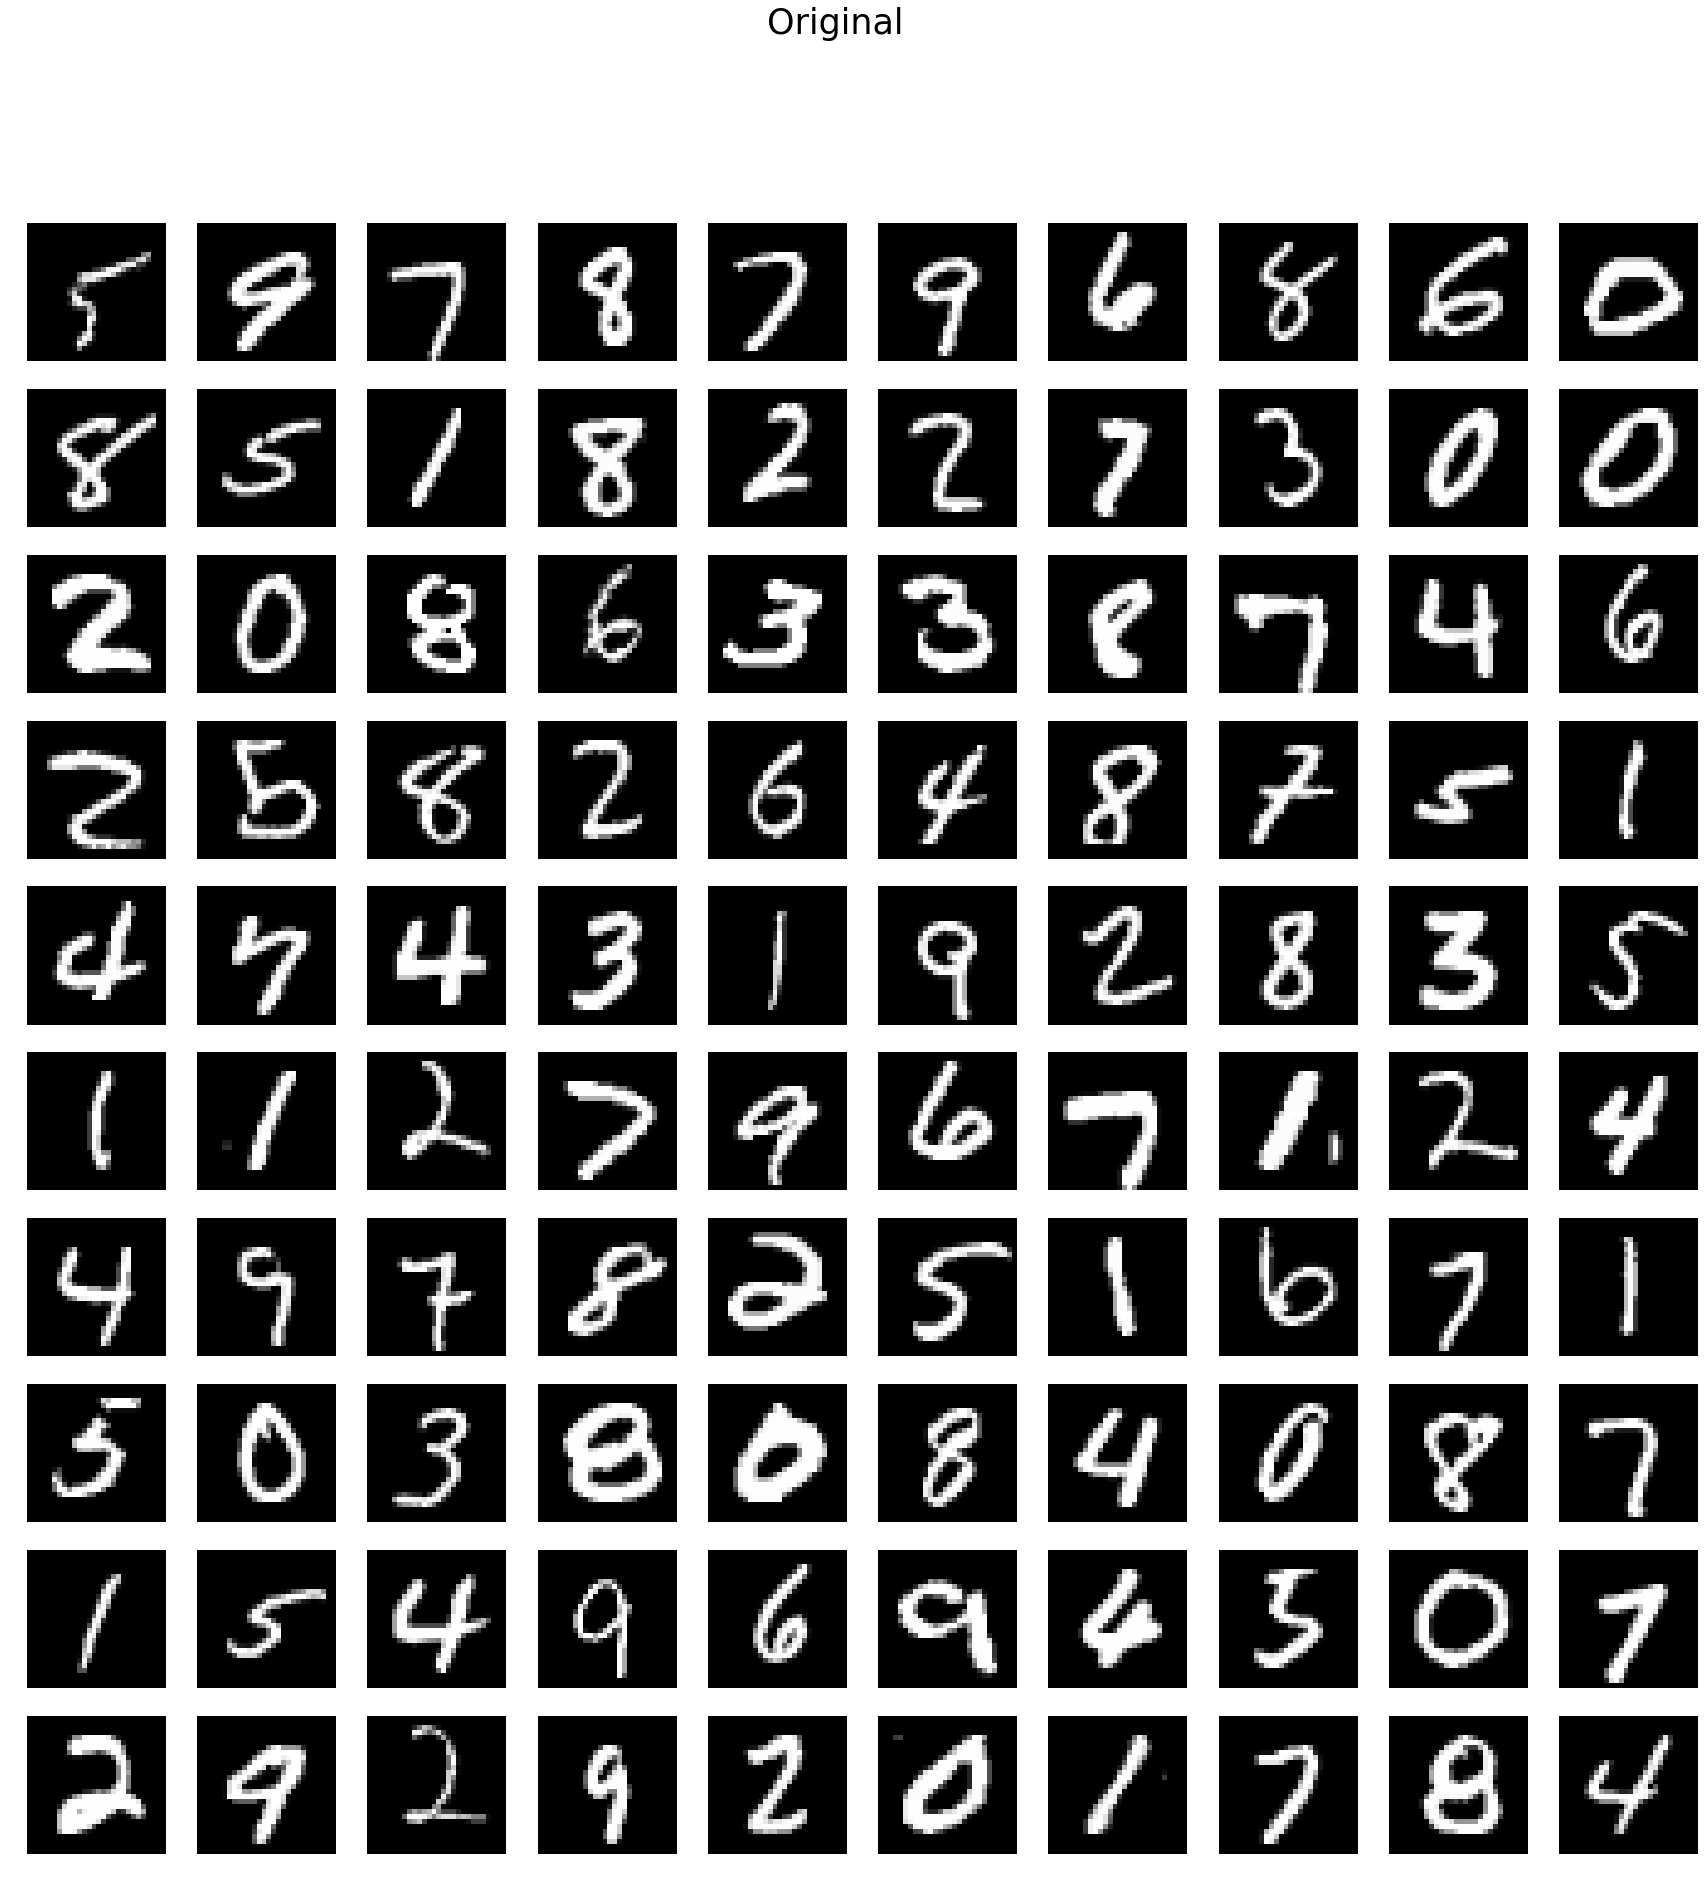

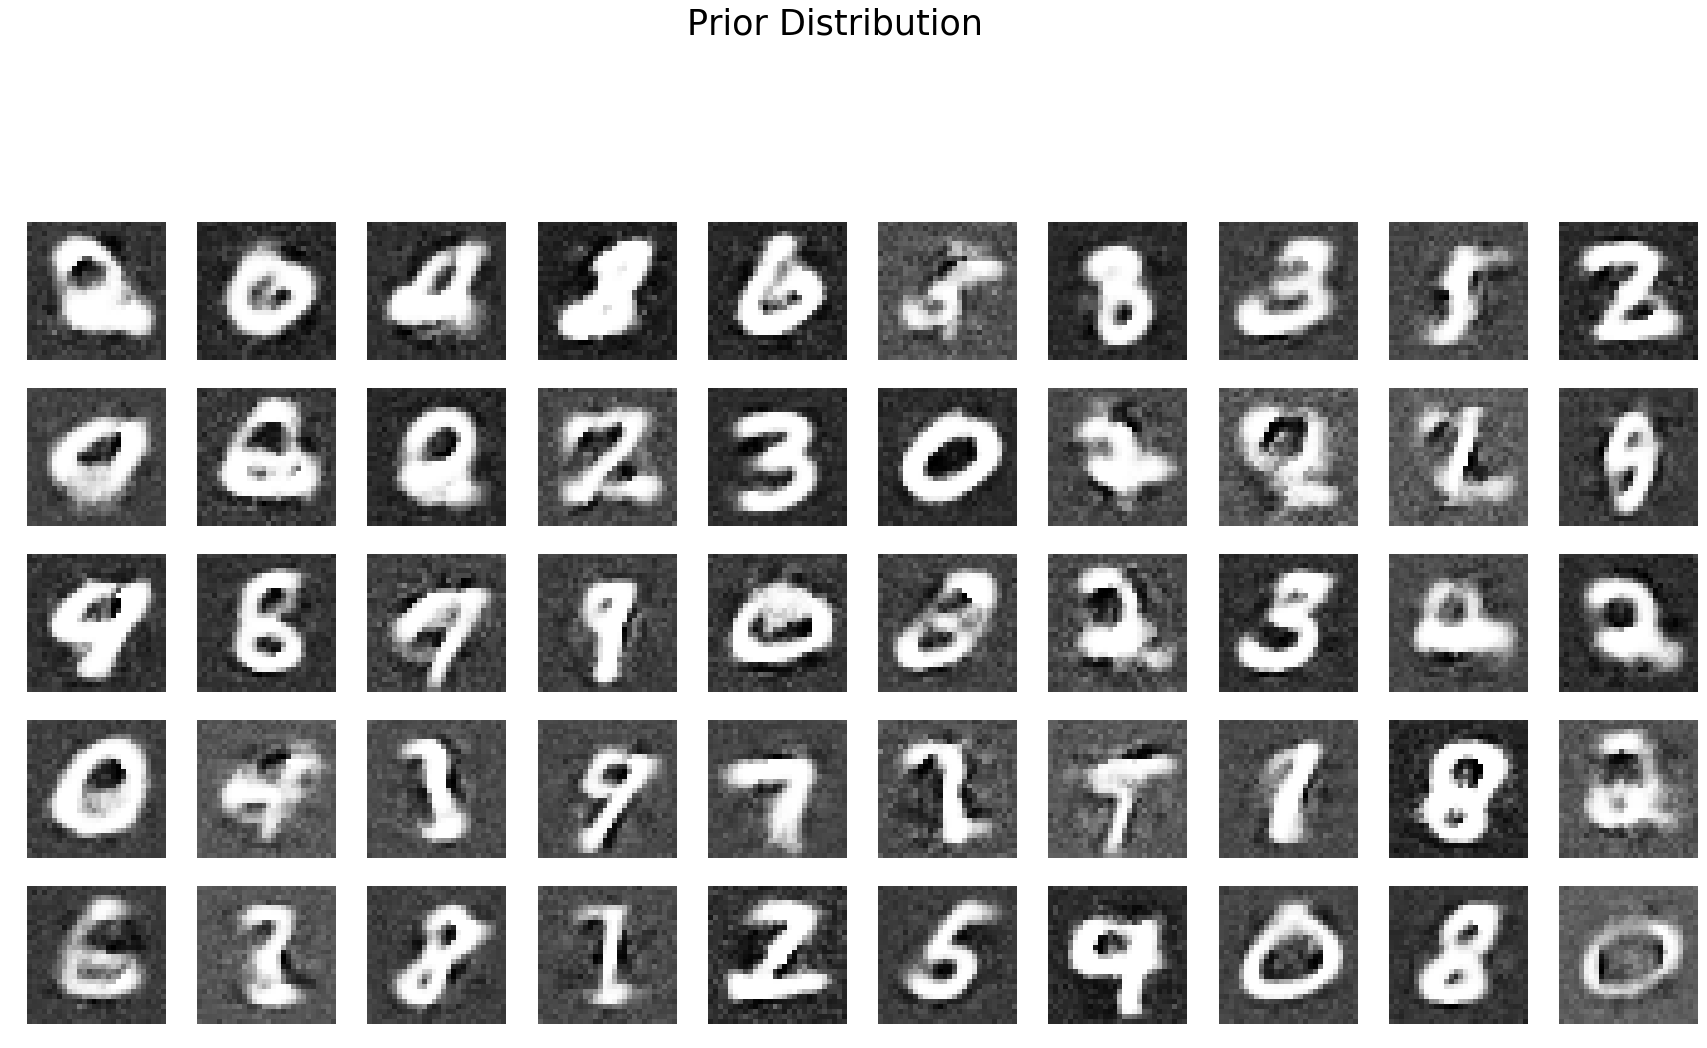

In [222]:
fig=plt.figure(figsize=(30,30))
fig1=plt.figure(figsize=(30,30))
fig2=plt.figure(figsize=(30,30))
idx=np.random.randint(0,x_test.shape[0],100)
test_images=x_test[idx]
output_imgs=AutoEncoder.predict(test_images)
test_images=test_images.reshape(test_images.shape[0],28,28)
output_imgs=output_imgs.reshape(output_imgs.shape[0],28,28)
half_batch=50
latent_real= 5*np.random.normal(size=(half_batch, encoded_dim))
reco_img=decoder.predict(latent_real)
reco_img=reco_img.reshape(reco_img.shape[0],28,28)
fig.suptitle('Reconstructed',fontsize=35)
fig1.suptitle('Original',fontsize=35)
fig2.suptitle('Prior Distribution',fontsize=35)
for index, image in enumerate(output_imgs):
    #img = img.reshape((28, 28))
    ax=fig.add_subplot(10,10,index+1)
    ax.set_axis_off()
    ax.imshow(image, cmap="gray")
for index, image in enumerate(test_images):
    #img = img.reshape((28, 28))
    ax=fig1.add_subplot(10,10,index+1)
    ax.set_axis_off()
    ax.imshow(image, cmap="gray")
for index, image in enumerate(reco_img):
    #img = img.reshape((28, 28))
    ax=fig2.add_subplot(10,10,index+1)
    ax.set_axis_off()
    ax.imshow(image, cmap="gray")
plt.show()
plt.close(fig)
plt.close(fig1)
plt.close(fig2)

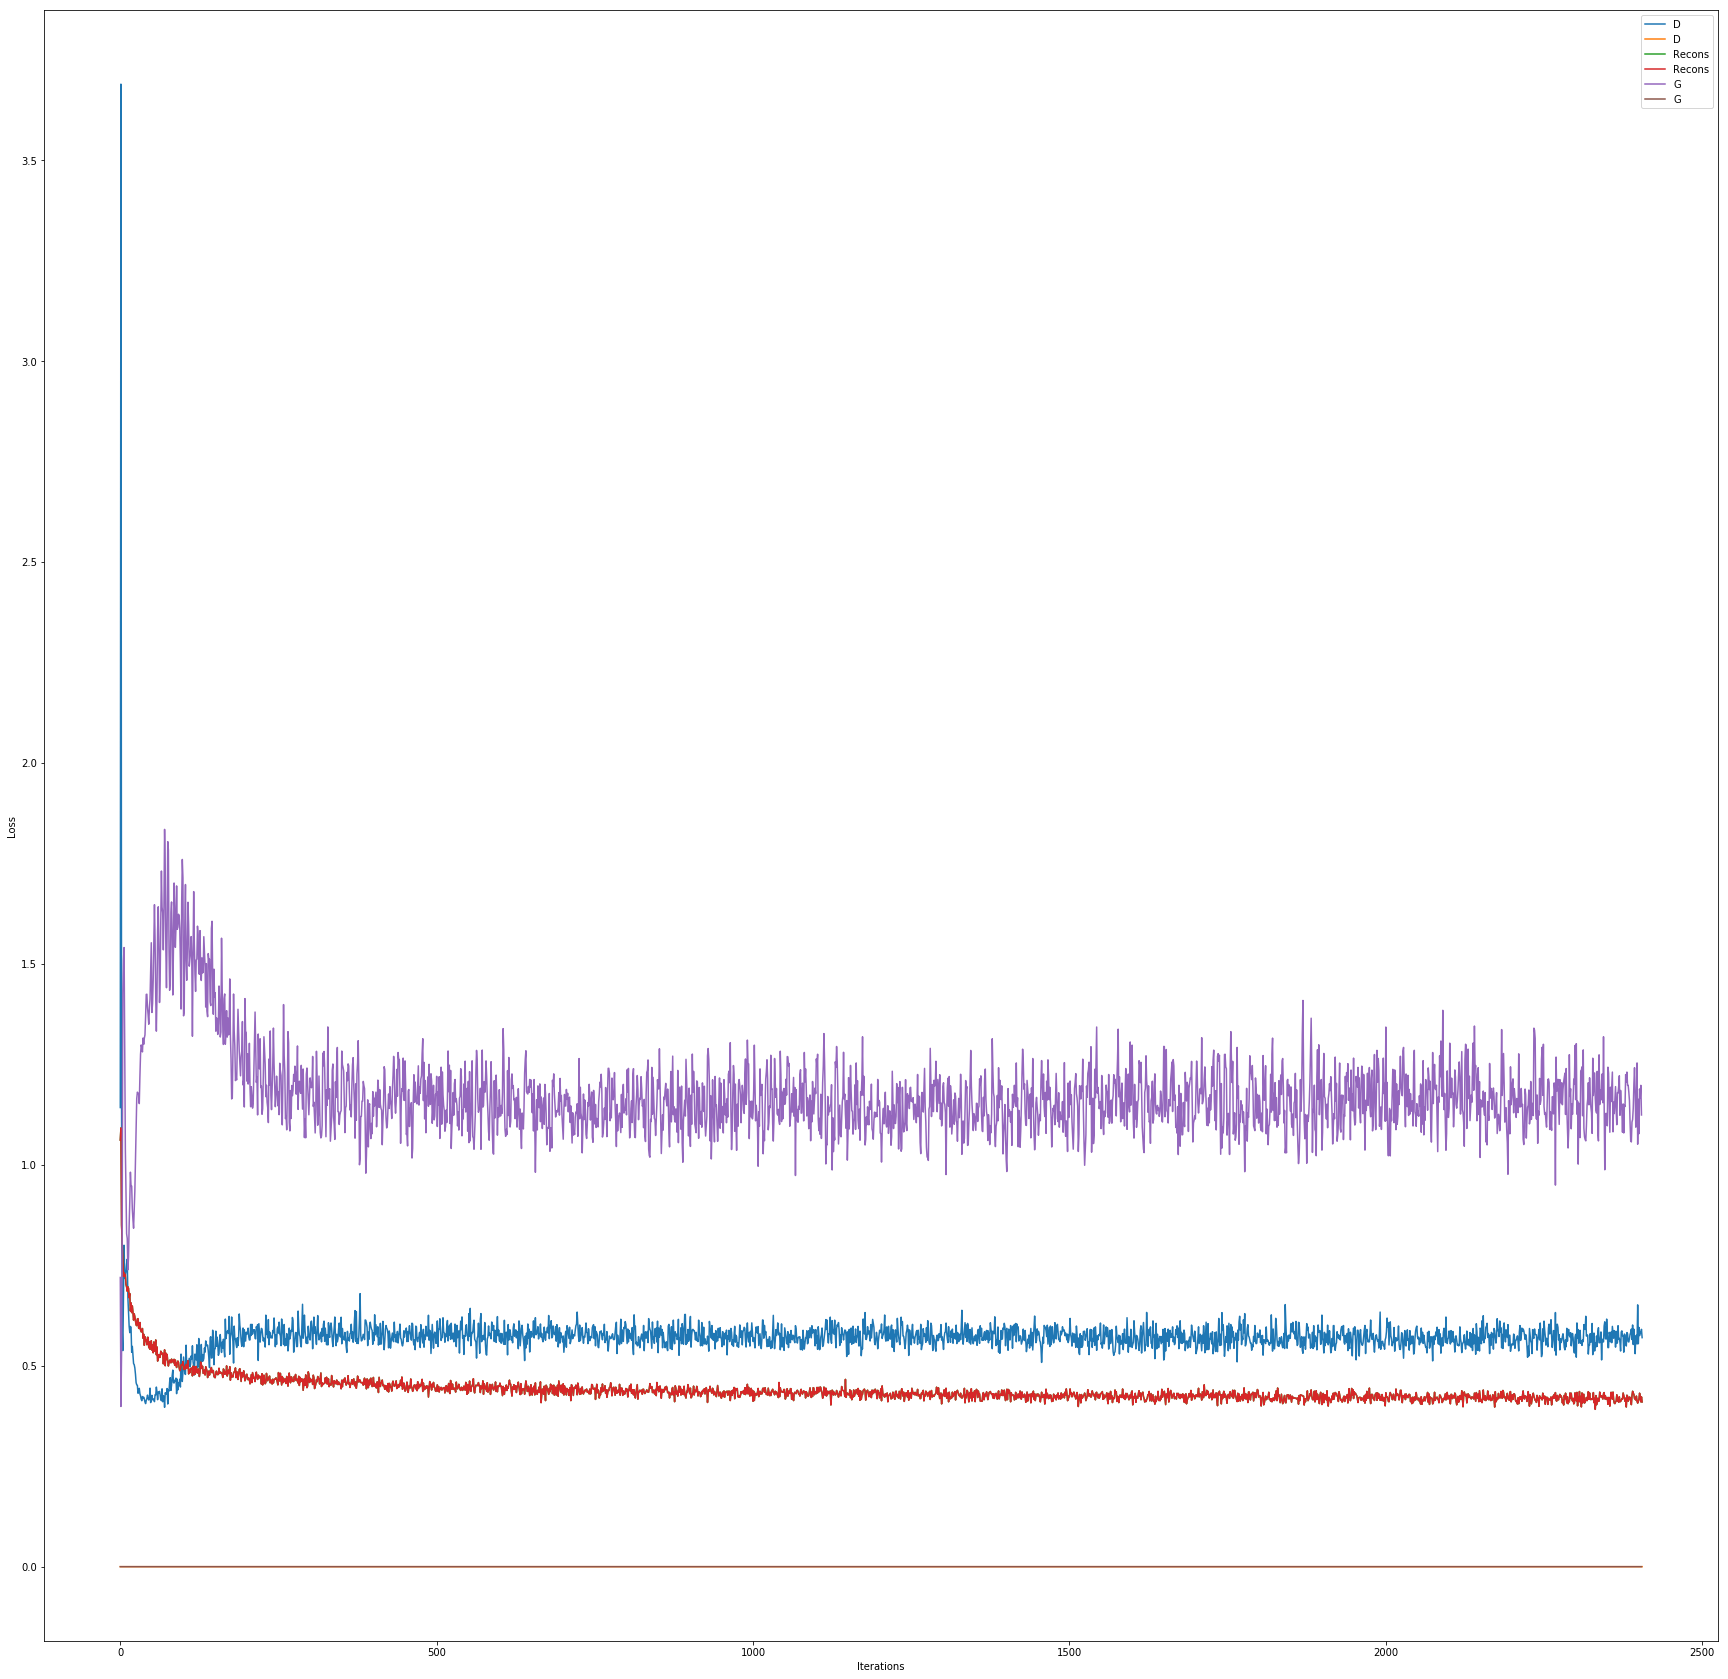

In [165]:
plt.figure(figsize=(30,30))
fig.suptitle('Generator Discriminator Reconstruction Loss',fontsize=16)
plt.plot(d_err,label='D')
plt.plot(recons,label='Recons')
plt.plot(g_e_err,label='G')
plt.xlabel('Iterations',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.legend()
plt.show()